# Japanese Coin SSD-Dataset Generator

日本の硬貨でSSDのデータセットをたくさん作るやつ

- 出力形式はVOCデータセットと同じような感じ
- アノテーションはxmlで出力
- ChainerCVのSSDサンプルで学習データセット形式として利用可能

In [48]:
from glob import glob
from PIL import Image, ImageDraw, ImageEnhance
import numpy as np
import copy
import os
import shutil
from dicttoxml import dicttoxml
from xml.dom.minidom import parseString
from xml.etree import ElementTree

## 諸関数の定義

In [49]:
# テクスチャのどれかを選択し、規定サイズに切り抜く
def get_back_img(_tex_img_list, is_rotate=True):
    # ランダムにテクスチャを切り出し
    tex_crop_start_x = np.random.randint(TEX_BASE_SIZE-IMG_SIZE)
    tex_crop_start_y = np.random.randint(TEX_BASE_SIZE-IMG_SIZE)
    crop_rect = (tex_crop_start_x, tex_crop_start_y, tex_crop_start_x + IMG_SIZE, tex_crop_start_y + IMG_SIZE)
    #print crop_rect

    tex_img_select = _tex_img_list[np.random.randint(len(_tex_img_list))]
    tex_img = tex_img_select.crop(crop_rect)
    if is_rotate:
        tex_img = tex_img.rotate(np.random.randint(4)*90)
    try:
        tex_img.transpose(np.random.randint(7))
    except:
        pass
    return tex_img

# ランダムなサイズにリサイズしたコインの配列を取得する
def get_resized_coin_list(_coin_img_list):
    # 硬貨のランダムの画像倍率にリサイズ
    coin_size_rate = (MAX_COIN_SIZE_RATE - MIN_COIN_SIZE_RATE) * np.random.rand() + MIN_COIN_SIZE_RATE
    #print coin_size_rate

    # リサイズした画像の配列を作成
    coin_resize_list = []
    for img_ in _coin_img_list:
        img = copy.copy(img_)
        img[0] = img[0].resize((tuple(np.int32(np.array(img[0].size)*coin_size_rate))), Image.BICUBIC)
        coin_resize_list.append(img)
        #print img[0].size, img[1]
    return coin_resize_list


def get_shuffled_coin_list(_coin_resize_list):
    # ランダムの硬貨の数だけ配列作成
    coin_num = np.random.randint(1,MAX_COIN_NUM)
    #print coin_num, "coins"

    pop_coin_list = []
    while len(pop_coin_list) < coin_num:
        rand_img = _coin_resize_list[np.random.randint(len(_coin_resize_list))]
        pop_coin_list.append(rand_img)
        #print COIN_LABELS.get(str(rand_img[1])),
    return pop_coin_list

# ランダムに決めたコインの位置を返す
def get_random_coin_pos(coin_size_w, coin_size_h, history_position = [],coin_size=0, overlap=True):
    counter = 0
    while counter < 100:
        # 適当に場所を決める
        paste_pos_w = np.random.randint(IMG_SIZE-coin_size_w)
        paste_pos_h = np.random.randint(IMG_SIZE-coin_size_h)
    
        # 履歴コイン座標との距離を計測し、近すぎる場合はやりなおす
        cont_flag = False
        for hist_pos in history_position:
            org_pos = np.array([paste_pos_w, paste_pos_h])
            hist_pos = np.array(hist_pos[0])[0:2]
            #print org_pos, hist_pos

            distance = np.linalg.norm(org_pos - hist_pos)
            # 75%以上は出るように調整
            if overlap and distance < coin_size * MIN_COINS_DISTANCE_RATE:
                #print "retry! dist:", distance
                cont_flag = True
                continue
        if cont_flag == True:
            counter += 1
            continue
        break
    
    return paste_pos_w, paste_pos_h    

# 合成画像と配置場所の情報を作成する
def get_dest_img(_pop_coin_list, overlap=True):
    dest_img = tex_img.copy()
    coin_pos_history = []
    for img in _pop_coin_list:
        paste_img = img[0]
        paste_img = paste_img.rotate(np.random.randint(360), expand=RECT_EXPAND)
        paste_img_w,paste_img_h = paste_img.size
        paste_pos_w, paste_pos_h = get_random_coin_pos(paste_img_w,paste_img_h, coin_pos_history, paste_img_w, overlap=overlap)
        dest_img.paste(paste_img, (paste_pos_w,paste_pos_h), paste_img.split()[-1])
        coin_pos_history.append([[paste_pos_w, paste_pos_h,
                                  paste_pos_w+paste_img_w, paste_pos_h+paste_img_h], img[1]])
    if np.random.randint(3) == 0:
        bright_rate = 0.9 - np.random.randint(5)/10.0
    elif np.random.randint(3) == 1:
        bright_rate = 1.1 + np.random.randint(5)/10.0
    else:
        bright_rate = 1.0
    #print "BRIGHT RATE :", bright_rate
    eim = ImageEnhance.Brightness(dest_img)
    dest_img = eim.enhance(bright_rate)
    return dest_img, coin_pos_history

# 確認用：ラベルと外枠を描画する
def draw_rectangle(img, _coin_pos_history):
    dr = ImageDraw.Draw(img)
    coin_sum = 0
    for val in _coin_pos_history:
        axiz,label = val
        stp = (axiz[0],axiz[1])
        edp = (axiz[2],axiz[3])
        col = (255,0,0)
        dr.rectangle((stp,edp),outline=col)
        
        coin_val = COIN_LABELS[label]
        coin_sum += coin_val
        dr.text(stp, str(COIN_LABELS[label]))
    dr.text((0,0), "COIN SUM = {}".format(str(coin_sum)))
    return img

# xml出力用のアノテーションdictを作成
def get_anno_xml(coin_pos_history):
    anno_xml_dict = []
    for each_coin in coin_pos_history:
        anno_dict = {}
        bbox = each_coin[0]
        label_num = each_coin[1]
        label = COIN_LABELS.get(str(label_num))
        anno_dict["name"] = label
        anno_dict["difficult"] = 0
        anno_dict["bndbox"] = {
            "xmin":bbox[0],
            "ymin":bbox[1],
            "xmax":bbox[2],
            "ymax":bbox[3],
        }
        anno_xml_dict.append(anno_dict)
    my_item_func = lambda x: 'object'
    xml = dicttoxml(anno_xml_dict, custom_root='annotation', attr_type=False, item_func=my_item_func)
    return xml

# xmlをファイルに出力する
def make_xml(xml_str, filename):
    e = ElementTree.fromstring(xml_str)

    tree = ElementTree.ElementTree(e)
    tree.write(filename)

---

## 1. 素材画像の読み込み

In [50]:
DATASET_MODE = "OSATU"
DATASET_MODE = "COIN"

In [51]:
if DATASET_MODE == "OSATU":
    # お札用
    IMG_SIZE = 300
    TEX_BASE_SIZE = 600

    MIN_COIN_SIZE_RATE = 0.2
    MAX_COIN_SIZE_RATE = 0.6
    MAX_COIN_NUM = 4

    MIN_COINS_DISTANCE_RATE = 0.8 # コインの重なりの許容値

    COIN_LABELS = {
        "1":1000,
        "2":5000,
        "3":10000,
    }
    COIN_IMG_PATH = "japanese_coin/osatu"
    PAR_DIR = "osatu"
    RECT_EXPAND = True
else:
    # コイン用
    IMG_SIZE = 300
    TEX_BASE_SIZE = 600

    MIN_COIN_SIZE_RATE = 0.3
    MAX_COIN_SIZE_RATE = 0.7
    MAX_COIN_NUM = 7

    MIN_COINS_DISTANCE_RATE = 0.7 # コインの重なりの許容値

    COIN_LABELS = {
        "1":1,
        "2":5,
        "3":10,
        "4":50,
        "5":100,
        "6":500,
    }
    COIN_IMG_PATH = "japanese_coin/coin"
    PAR_DIR = "coin"
    RECT_EXPAND = False
print ("Datasets  Mode : "+DATASET_MODE)

Datasets  Mode : COIN


In [52]:
TEX_IMG_PATH  = "japanese_coin/tex"

IMG_DIR = os.path.join(PAR_DIR, "JPEGImages")
ANN_DIR = os.path.join(PAR_DIR, "Annotations")
TXT_DIR = os.path.join(PAR_DIR, "ImageSets")
TXT_SUB_DIR = "Main"

In [53]:
coin_img_path_list = sorted(glob(COIN_IMG_PATH + "/*"))
tex_img_path_list = sorted(glob(TEX_IMG_PATH + "/*"))

In [54]:
coin_img_list = []
for val in coin_img_path_list:
    img = Image.open(val)
    lbl = img.filename.replace("_","")[-6]
    img = img.convert("RGBA")
    if img.size[0] > 300:
        img.thumbnail((300, 300), Image.ANTIALIAS)
    coin_img_list.append([img, lbl])
    #print lbl, img.size

tex_img_list = []

for i,val in enumerate(tex_img_path_list):
    img = Image.open(val)
    img = img.resize((TEX_BASE_SIZE,TEX_BASE_SIZE))
    tex_img_list.append(img)

print ("Coins:{} pisc, Back:{} pics".format(len(coin_img_list), len(tex_img_list)))

Coins:24 pisc, Back:55 pics


## 2. 画像生成

効果は以下の加工を行う

- ランダム回転
- ランダム拡大縮小
- ランダム輝度
- ランダム彩度

### 2.1. 画像生成 1枚テスト

ポップ時に配置済みコインとの距離を計測し、重ならないようにいい感じにしてあげる

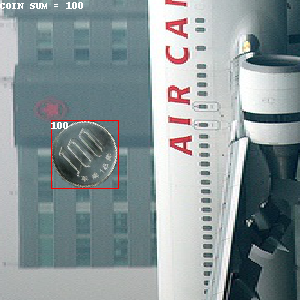

In [104]:
# 背景取得
tex_img = get_back_img(tex_img_list, is_rotate=True)

# リサイズしたコイン画像取得
coin_resize_list = get_resized_coin_list(coin_img_list)


# 配置するコインリスト取得
pop_coin_list = get_shuffled_coin_list(coin_resize_list)

# ランダム配置のコイン画像と位置を取得
dest_img, coin_pos_history = get_dest_img(pop_coin_list)
# アノテーション取得
out_xml = get_anno_xml(coin_pos_history)

# 領域枠を描画
draw_rectangle(dest_img, coin_pos_history)
dest_img

### 2.3. XML 出力確認

In [105]:
dom = parseString(out_xml)
print(dom.toprettyxml())

<?xml version="1.0" ?>
<annotation>
	<object>
		<difficult>0</difficult>
		<name>100</name>
		<bndbox>
			<ymax>188</ymax>
			<xmax>118</xmax>
			<ymin>120</ymin>
			<xmin>51</xmin>
		</bndbox>
	</object>
</annotation>



## 3. 一括出力

### 3.1. 出力ファイル構成

VOCデータセットの形式ぽい感じで出力する

- ./coin
    - /JPEGImages **生成した画像**
    - /Annotations **画像に対する領域情報xml**
    - /ImageSets **train/valの振り分け情報**

In [106]:
# 出力ディレクトリ作成
if os.path.exists(IMG_DIR):
    shutil.rmtree(IMG_DIR)
os.mkdir(IMG_DIR)

if os.path.exists(ANN_DIR):
    shutil.rmtree(ANN_DIR)
os.mkdir(ANN_DIR)

if os.path.exists(TXT_DIR):
    shutil.rmtree(TXT_DIR)
os.mkdir(TXT_DIR)
os.mkdir(os.path.join(TXT_DIR, TXT_SUB_DIR))

### 3.2. 生成画像一括出力

In [107]:
GENERATE_NUM = 20
out_img_name = "coin_{0:04d}"
out_img_ext = ".jpg"
out_ann_ext = ".xml"
coin_counter = np.int32(np.zeros(len(COIN_LABELS)))
train_test_list = {"trainval":[], "test":[]}
for val in range(GENERATE_NUM):
    # 背景取得
    tex_img = get_back_img(tex_img_list, is_rotate=False)

    # リサイズしたコイン画像取得
    coin_resize_list = get_resized_coin_list(coin_img_list)

    # 配置するコインリスト取得
    pop_coin_list = get_shuffled_coin_list(coin_resize_list)

    # ランダム配置のコイン画像と位置を取得
    dest_img, coin_pos_history = get_dest_img(pop_coin_list)

    # 領域枠を描画
    #dest_img = draw_rectangle(dest_img, coin_pos_history)
    
    # 画像出力
    dest_img.save(os.path.join(IMG_DIR, out_img_name.format(val) + out_img_ext))
        
    # アノテーション出力
    out_xml = get_anno_xml(coin_pos_history)
    make_xml(out_xml, os.path.join(ANN_DIR,out_img_name.format(val) + out_ann_ext))
    
    # 学習用/検証用のデータ分け
    append_target = "trainval" if np.random.randint(2) == 0 else "test"
    train_test_list[append_target].append(out_img_name.format(val)+"\n")
        
    # 各枚数集計
    for hist in coin_pos_history:
        coin_counter[int(hist[1])-1] += 1
        
    # 進捗
    if not val == 0 and val % 100 == 0:
        print( "{} images done".format(val))
print( "{} images generated".format(GENERATE_NUM))

20 images generated


### 3.3. 生成結果確認

In [108]:
# 各コインの分布確認
for i,val in enumerate(coin_counter):
    print ("{}:\t{} coins.".format(COIN_LABELS[str(i+1)],val))

1:	8 coins.
5:	10 coins.
10:	16 coins.
50:	9 coins.
100:	12 coins.
500:	12 coins.


### 3.4. 学習用、テスト用に画像をわける

In [109]:
TRAINVAL_TXT_PATH = os.path.join(TXT_DIR, TXT_SUB_DIR,("trainval.txt"))
TEST_TXT_PATH     = os.path.join(TXT_DIR, TXT_SUB_DIR,("test.txt"))

with open(TRAINVAL_TXT_PATH, 'w') as f:
      f.writelines(train_test_list["trainval"])
with open(TEST_TXT_PATH, 'w') as f:
      f.writelines(train_test_list["test"])

---

## 4. Chainer のデータセットとして読み込みテスト

ChainerCV の voc_bbox_dataset.py はそのままだとVOCデータセット2012の20クラス固定となっているので、外部で定義できるように改造した lib.voc_bbox_dataset を使う

In [110]:
from lib.voc_bbox_dataset import VOCBboxDataset

In [111]:
train = VOCBboxDataset(data_dir=PAR_DIR, split='trainval')
test = VOCBboxDataset(data_dir=PAR_DIR, split='test', use_difficult=True, return_difficult=True)
len(train), len(test)

(11, 9)